the description of the data set can be found in the link:
http://kdd.ics.uci.edu/databases/kddcup99/task.html

In [1]:
import os
from collections  import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
%matplotlib inline

In [2]:
file = os.path.join('/home/mateusz/Documents/kddcup.data_10_percent_corrected')

In [3]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [42]:
#Differentiating between nominal, binary and numeric features

#root shell is marked as a continuous feature in the kddcup.names
#file, but ut us supposed to be a binary feature according to the data set documentation

col_names = np.array(header_names)

nominal_idx = [1,2,3]
binary_idx = [6, 11,13,14,20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [43]:
#training_attack_types.txt maps each of the 22 different attacks to 1 of 4 catefories
#file obrained from http://kdd.ics.udi.edu/databases/kddcup99/training_attack_types
category = defaultdict(list)
category['benign'].append('normal.')

with open(r'/home/mateusz/Documents/nsl-kdd/training_attack_types.txt', mode = 'r', encoding = 'utf-8-sig') as f:
    for line in f.readlines():
        print(line.strip().split(' '))
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

['back.', 'dos']
['land.', 'dos']
['neptune.', 'dos']
['pod.', 'dos']
['smurf.', 'dos']
['teardrop.', 'dos']
['apache2.', 'dos']
['udpstorm.', 'dos']
['processtable.', 'dos']
['worm.', 'dos']
['satan.', 'probe']
['ipsweep.', 'probe']
['nmap.', 'probe']
['portsweep.', 'probe']
['mscan.', 'probe']
['saint.', 'probe']
['guess_passwd.', 'r2l']
['ftp_write.', 'r2l']
['imap.', 'r2l']
['phf.', 'r2l']
['multihop.', 'r2l']
['warezmaster.', 'r2l']
['warezclient.', 'r2l']
['spy.', 'r2l']
['xlock.', 'r2l']
['xsnoop.', 'r2l']
['snmpguess.', 'r2l']
['snmpgetattack.', 'r2l']
['httptunnel.', 'r2l']
['sendmail.', 'r2l']
['named.', 'r2l']
['buffer_overflow.', 'u2r']
['loadmodule.', 'u2r']
['rootkit.', 'u2r']
['perl.', 'u2r']
['sqlattack.', 'u2r']
['xterm.', 'u2r']
['ps.', 'u2r']
['mailbomb.', 'r2l']


In [44]:
#adding attack_category feature from the list of categories in text file
data = pd.read_csv(file, names=header_names)
data['attack_category'] = data['attack_type'] \
                                .map(lambda x: attack_mapping[x])
data.drop(['success_pred'], axis=1, inplace=True)

In [45]:
data_attack_types = data['attack_type'].value_counts()
data_attack_cats = data['attack_category'].value_counts()

It is seen that the most frequently occuring type of attack is smurf and it's almost three times more frequent than normal behavior for this data set.

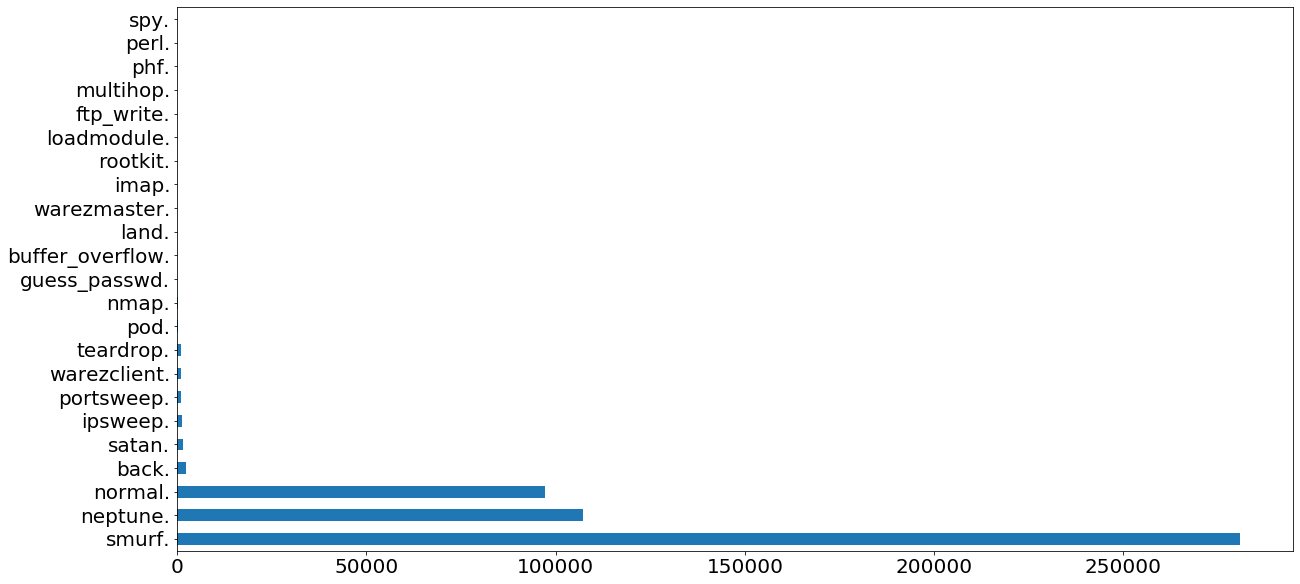

In [46]:
data_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

Denial of System far outnumber the number of normal activities in the network for this data set.

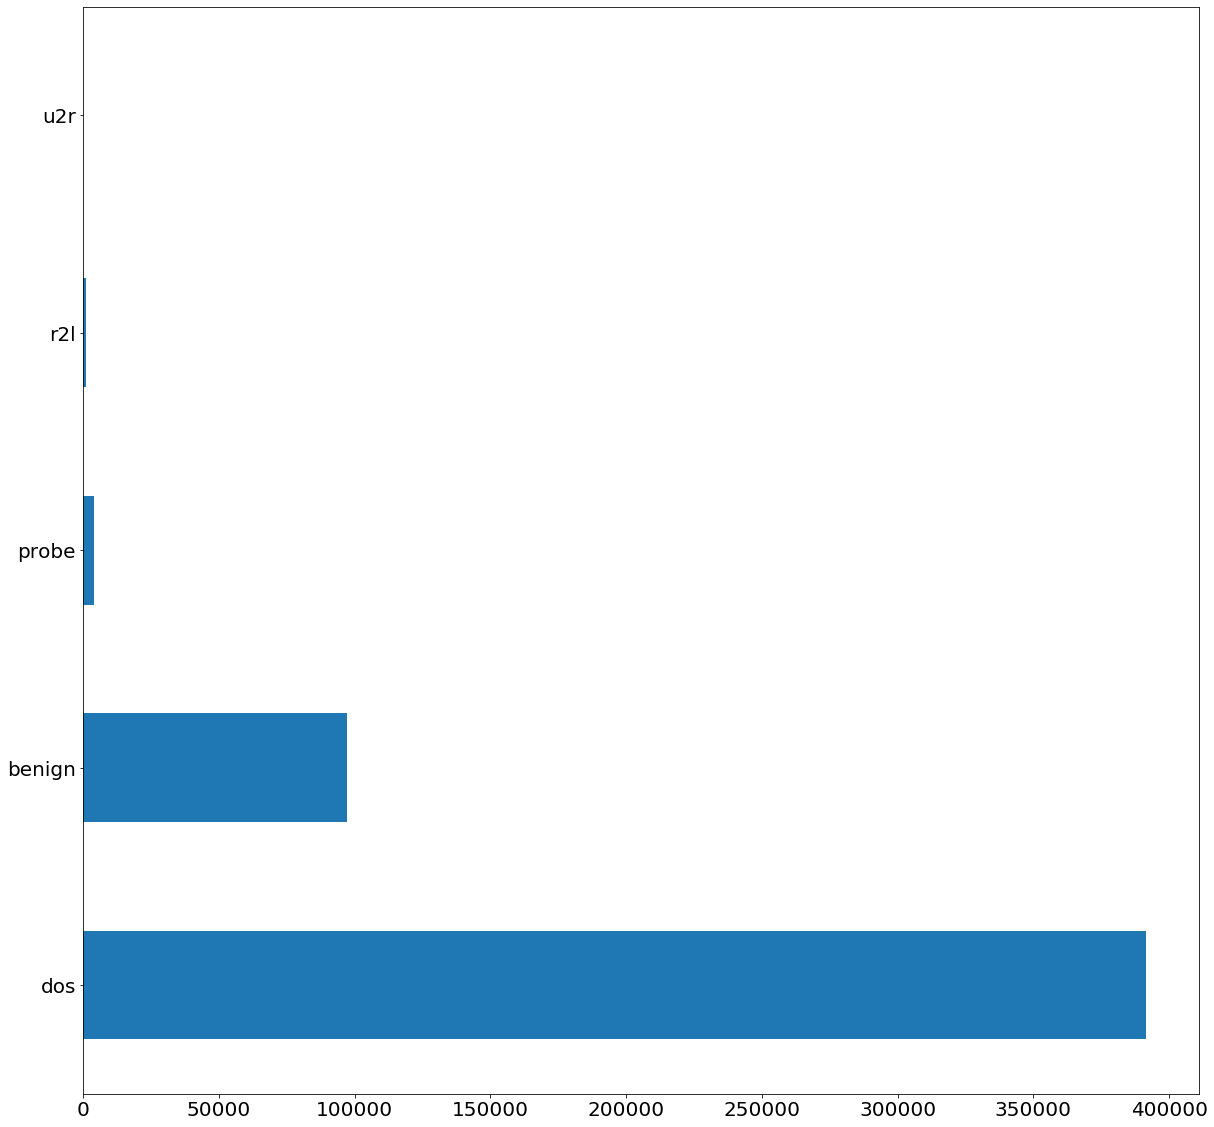

In [47]:
data_attack_cats.plot(kind='barh', figsize=(20,20), fontsize=20)

In [48]:
data[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,494021.0,0.000045,0.006673,0.0,0.0,0.0,0.0,1.0
logged_in,494021.0,0.148247,0.355345,0.0,0.0,0.0,0.0,1.0
root_shell,494021.0,0.000111,0.010551,0.0,0.0,0.0,0.0,1.0
su_attempted,494021.0,0.000036,0.007793,0.0,0.0,0.0,0.0,2.0
is_host_login,494021.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
is_guest_login,494021.0,0.001387,0.037211,0.0,0.0,0.0,0.0,1.0


From the table above it's seen that there is number 2 in binary feature 'su_attempted'. I am going to fix it by changing the value to 0. Let's investigate how many of these values are in su_attempted

In [49]:
data.groupby(['su_attempted']).size()

su_attempted
0    494009
1         6
2         6
dtype: int64

In [50]:
#Fixing this discrepancy
data['su_attempted'].replace(2, 0, inplace=True)
data.groupby(['su_attempted']).size()

su_attempted
0    494015
1         6
dtype: int64

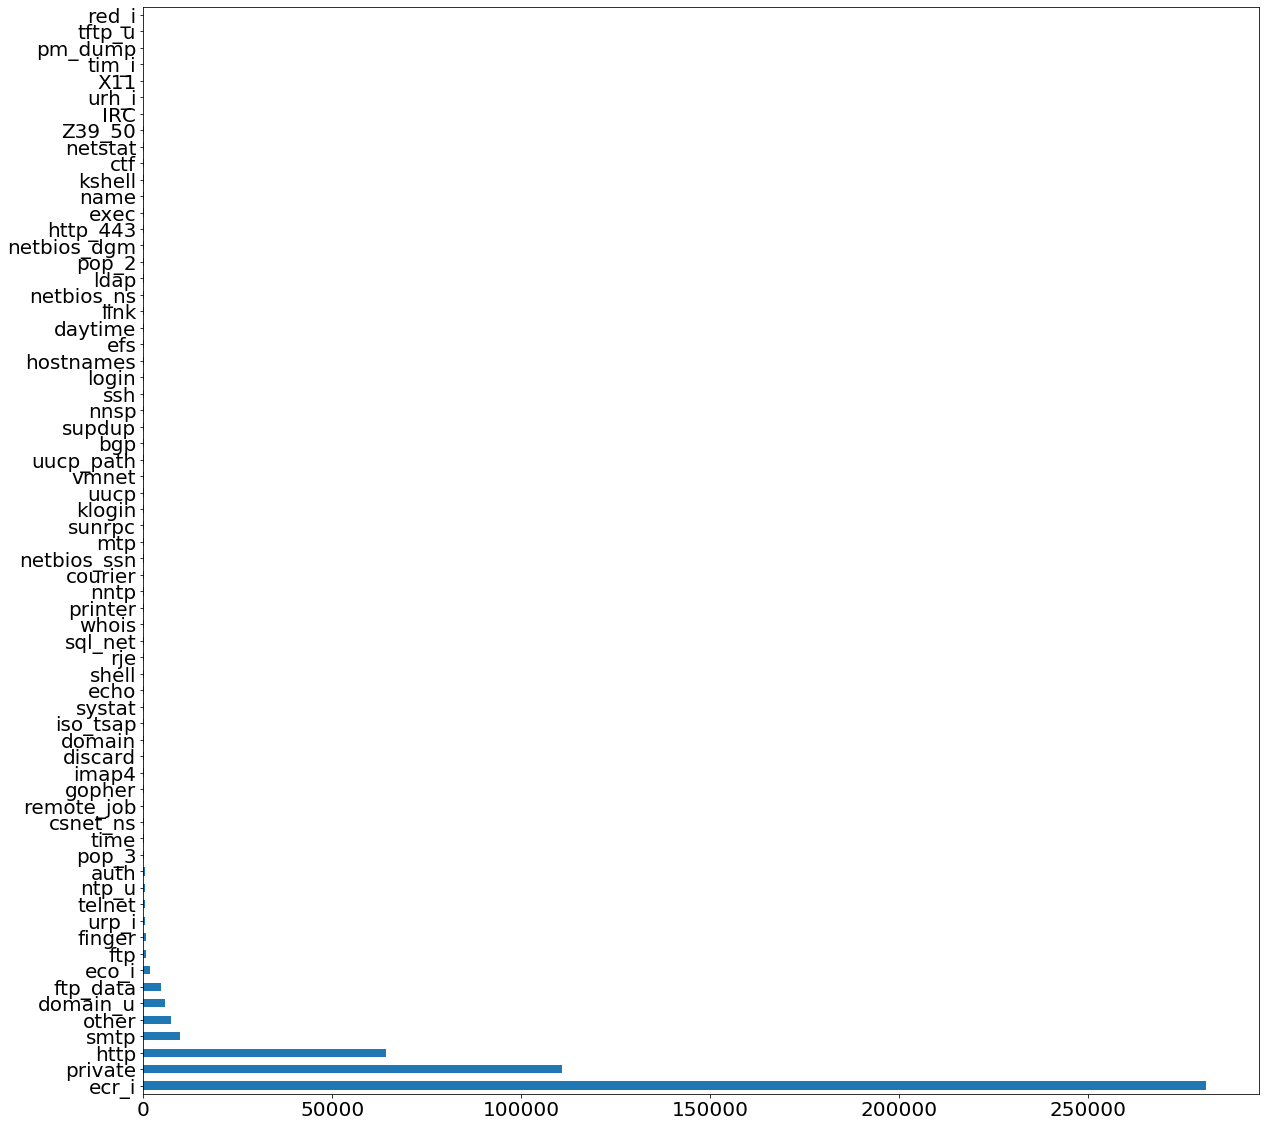

In [51]:
service = data['service'].value_counts()
service.plot(kind='barh', figsize=(20,20), fontsize=20)

We are going to transform the categories of the feature 'service' into ecr_i, private, http, others

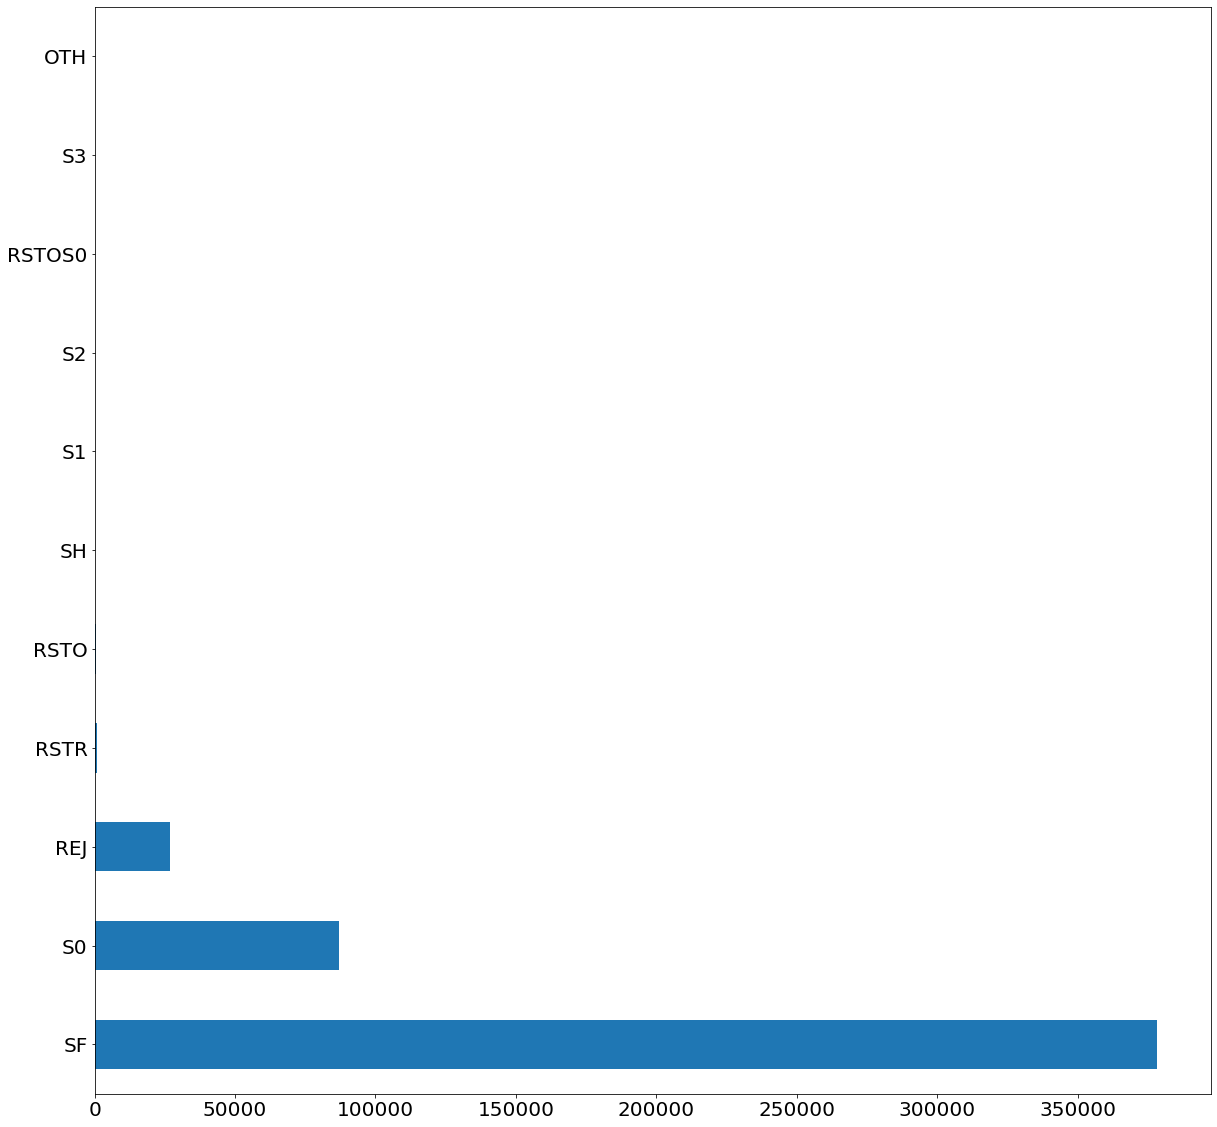

In [52]:
flag = data['flag'].value_counts()
flag.plot(kind='barh', figsize=(20,20), fontsize=20)

We are going to transform the categories of feature 'flag' into SF, SO and others

In [53]:
series = pd.value_counts(data.flag)
mask = (series/series.sum() * 100).lt(10)
# To replace df['column'] use np.where I.e 
data['flag'] = np.where(data['flag'].isin(series[mask].index),'Other',data['flag'])

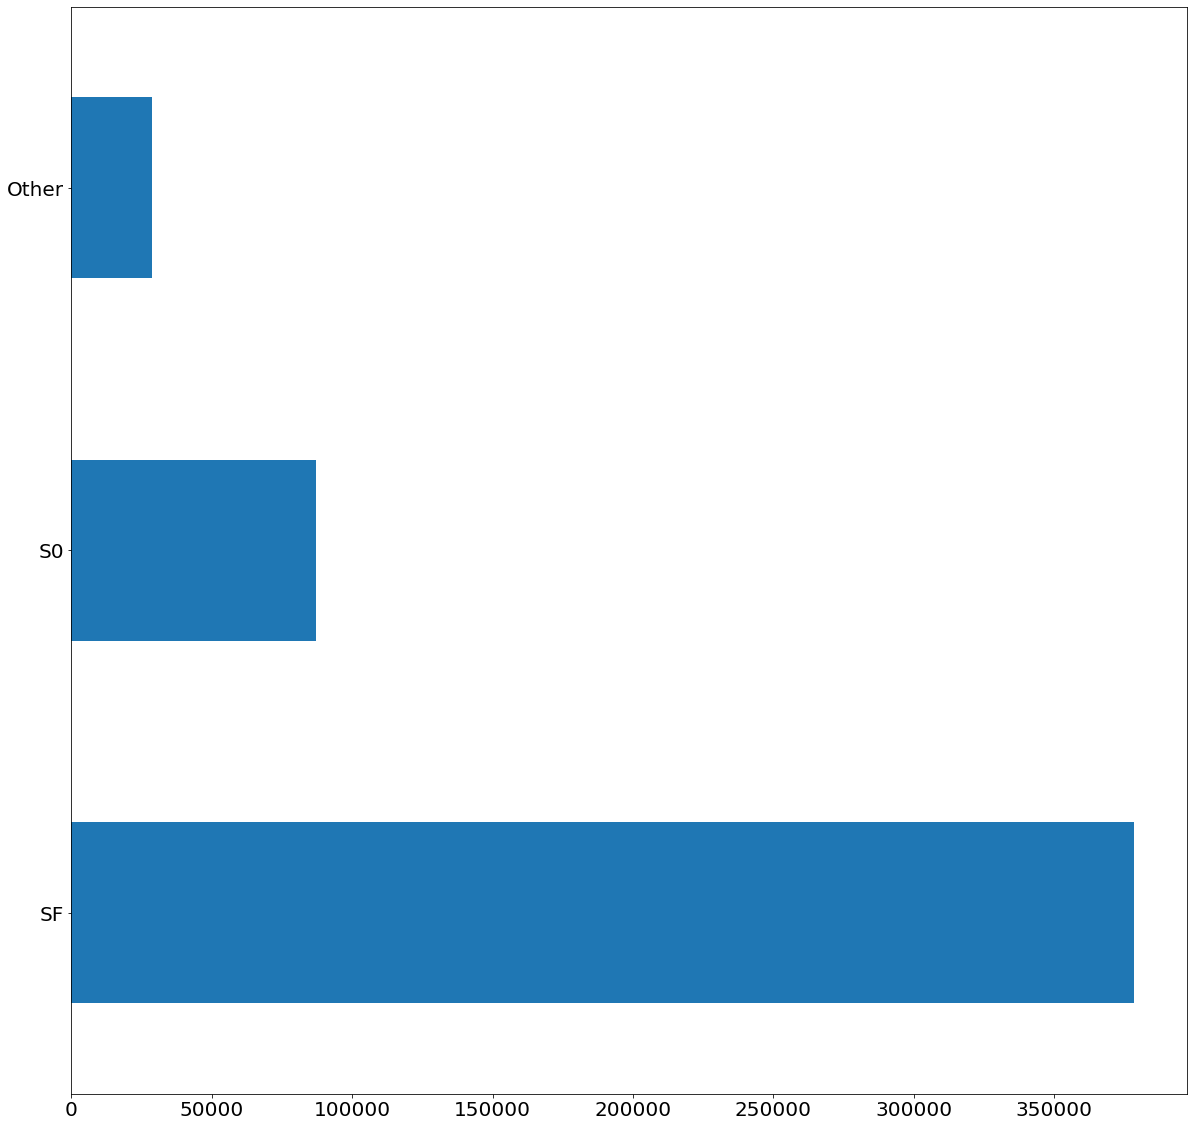

In [54]:
flag = data['flag'].value_counts()
flag.plot(kind='barh', figsize=(20,20), fontsize=20)

In [55]:
series = pd.value_counts(data.service)
mask = (series/series.sum() * 100).lt(10)
data['service'] = np.where(data['service'].isin(series[mask].index),'Other',data['service'])

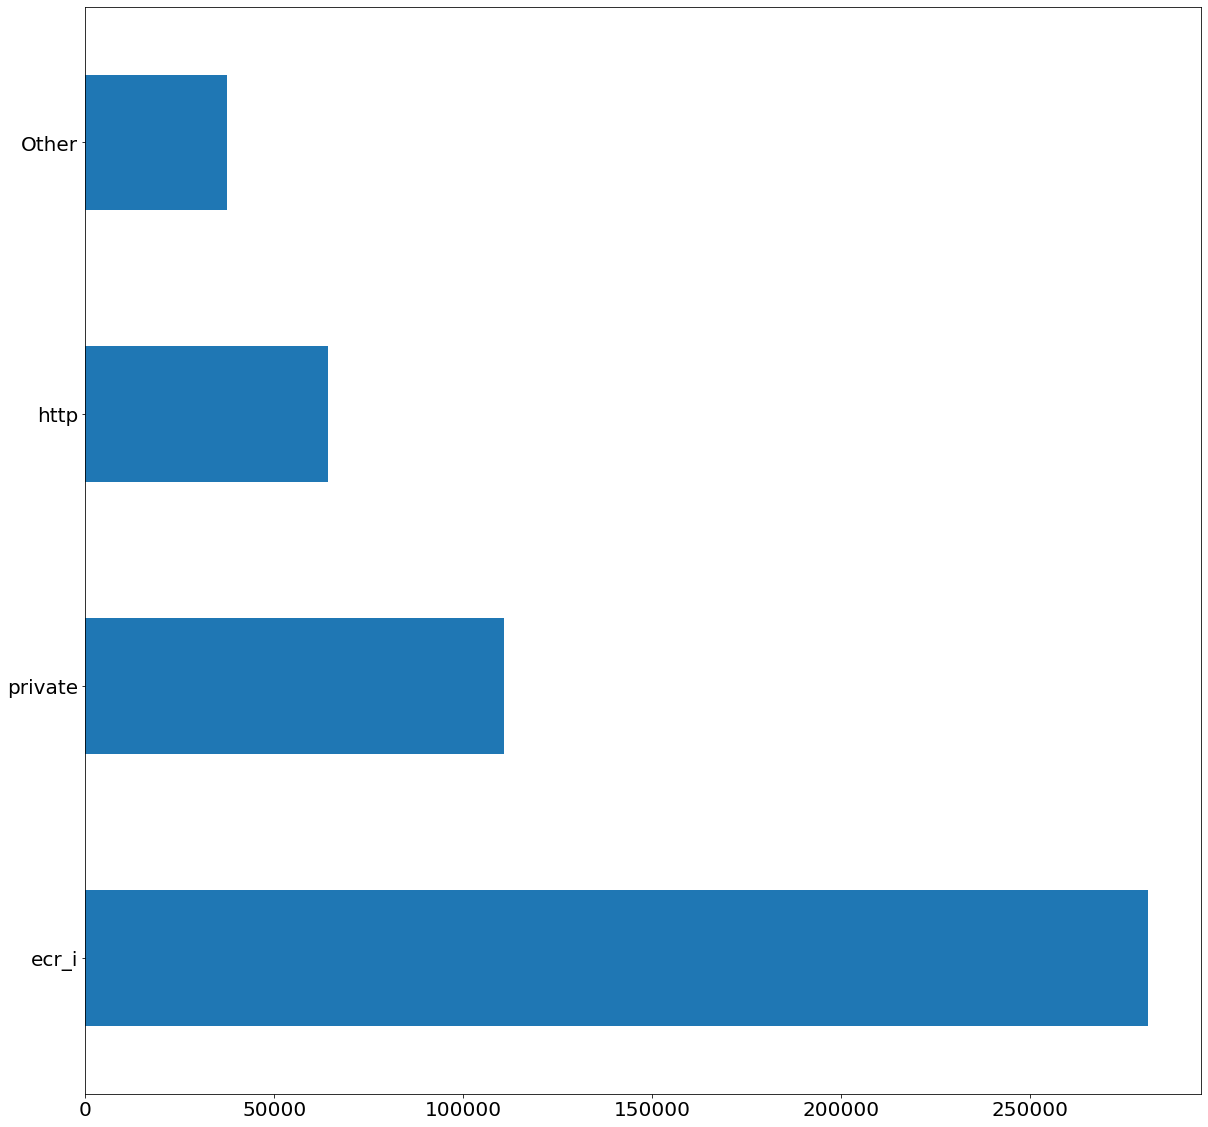

In [56]:
service = data['service'].value_counts()
service.plot(kind='barh', figsize=(20,20), fontsize=20)

In [57]:
#one hot encoding for categorical variables 
protocol_dummies = pd.get_dummies(data['protocol_type'])
service_dummies = pd.get_dummies(data['service'])
flag_dummies = pd.get_dummies(data['flag'])

In [58]:
col_names = np.array(['protocol_dummies', 'service_dummies', 'flag_dummies'])
dummy_idx = [0,1,2]
dummy_var = col_names[dummy_idx].tolist()

In [59]:
#merging dummy variables with data
data = data.merge(protocol_dummies, left_index=True, right_index=True)

In [60]:
#merging dummy variables with data
data = data.merge(service_dummies, left_index=True, right_index=True)

In [61]:
#merging dummy variables with data
data = data.merge(flag_dummies, left_index=True, right_index=True)

In [62]:
#dropping categorical variables 
data = data.drop(columns = ['protocol_type','service','flag'])

In [63]:
data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,icmp,tcp,udp,Other_x,ecr_i,http,private,Other_y,S0,SF
0,0,181,5450,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,0,239,486,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,0,235,1337,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,219,1337,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0,217,2032,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,310,1881,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
494017,0,282,2286,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
494018,0,203,1200,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
494019,0,291,1200,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


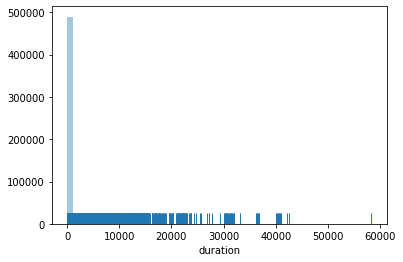

In [64]:
sns.distplot(data['duration'], kde=False, rug=True);

There is a large number of values 0 in the feature 'duration'. I am going to carry out log transformation on this feature.

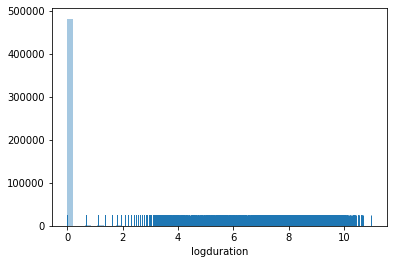

In [65]:
data['logduration'] = np.log((data['duration']+1))
sns.distplot(data['logduration'], kde=False, rug=True);

Majority of values in the feature 'duration'is zero due to either some technical issue or the time of the connection is too short for the device to record the value precisely.
I will treat these values as missing values.

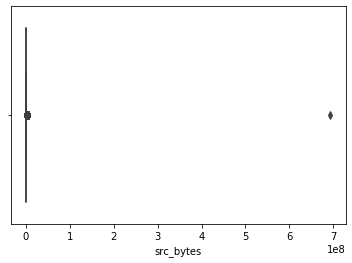

In [66]:
sns.boxplot(data['src_bytes'])

Paper about attribute ratio feature selection
https://pdfs.semanticscholar.org/6adf/0033a4428b80179e4a76b8f27ceea496d931.pdf
    

In [67]:
#Using "Attribute Ratio" (AR) feature selection
averages = data.loc[:, numeric_cols].mean()
averages_per_class = data[numeric_cols+['attack_category']].groupby('attack_category').mean()


AR = {}
for col in numeric_cols:
    AR[col] = max(averages_per_class[col])/averages[col]

AR #the score of AR corresponds to the feature's importance. 

/home/mateusz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


{'duration': 11.666535174349237,
 'src_bytes': 89.89015372112972,
 'dst_bytes': 83.24956212405806,
 'wrong_fragment': 1.2620025647706778,
 'urgent': 1357.2005494505495,
 'hot': 214.0827869835126,
 'num_failed_logins': 327.5923741859088,
 'num_compromised': 118.63735229092018,
 'num_root': 69.45730344014046,
 'num_file_creations': 728.0683321351546,
 'num_shells': 1231.5338319088319,
 'num_access_files': 19.077116156935435,
 'num_outbound_cmds': nan,
 'count': 1.2504553366116176,
 'srv_count': 1.2524333504281717,
 'serror_rate': 1.2553540098736804,
 'srv_serror_rate': 1.2549631420897842,
 'rerror_rate': 9.8750626627681,
 'srv_rerror_rate': 9.79457226361428,
 'same_srv_rate': 1.259612122292401,
 'diff_srv_rate': 19.302308862123088,
 'srv_diff_host_rate': 7.667906397535019,
 'dst_host_count': 1.0946006323011777,
 'dst_host_srv_count': 1.0710167597942795,
 'dst_host_same_srv_rate': 1.1210058726903738,
 'dst_host_diff_srv_rate': 19.09779508492937,
 'dst_host_same_src_port_rate': 1.193255035

In [68]:
dummy_variables

[        icmp  tcp  udp
 0          0    1    0
 1          0    1    0
 2          0    1    0
 3          0    1    0
 4          0    1    0
 ...      ...  ...  ...
 494016     0    1    0
 494017     0    1    0
 494018     0    1    0
 494019     0    1    0
 494020     0    1    0
 
 [494021 rows x 3 columns],         Other  ecr_i  http  private
 0           0      0     1        0
 1           0      0     1        0
 2           0      0     1        0
 3           0      0     1        0
 4           0      0     1        0
 ...       ...    ...   ...      ...
 494016      0      0     1        0
 494017      0      0     1        0
 494018      0      0     1        0
 494019      0      0     1        0
 494020      0      0     1        0
 
 [494021 rows x 4 columns],         Other  S0  SF
 0           0   0   1
 1           0   0   1
 2           0   0   1
 3           0   0   1
 4           0   0   1
 ...       ...  ..  ..
 494016      0   0   1
 494017      0   0   1
 49

In [73]:
binary_cols

['land',
 'logged_in',
 'root_shell',
 'su_attempted',
 'is_host_login',
 'is_guest_login']

In [69]:
def binary_AR(df, col):
    series_zero = data[data[col] == 0].groupby('attack_category').size()
    series_one = data[data[col] == 1].groupby('attack_category').size()
    return max(series_one/series_zero)

In [74]:
for col in binary_cols:
    cur_AR = binary_AR(data, col)
    if cur_AR:
        AR[col] = cur_AR

In [106]:
import operator
AR = dict((k, v) for k,v in AR.items() if not np.isnan(v))
sorted_AR = sorted(AR.items(), key=lambda x:x[1], reverse=True)

In [107]:
sorted_AR

[('urgent', 1357.2005494505495),
 ('num_shells', 1231.5338319088319),
 ('num_file_creations', 728.0683321351546),
 ('num_failed_logins', 327.5923741859088),
 ('hot', 214.0827869835126),
 ('num_compromised', 118.63735229092018),
 ('src_bytes', 89.89015372112972),
 ('dst_bytes', 83.24956212405806),
 ('num_root', 69.45730344014046),
 ('dst_host_srv_diff_host_rate', 28.33349254484438),
 ('diff_srv_rate', 19.302308862123088),
 ('dst_host_diff_srv_rate', 19.09779508492937),
 ('num_access_files', 19.077116156935435),
 ('logged_in', 11.942528735632184),
 ('duration', 11.666535174349237),
 ('rerror_rate', 9.8750626627681),
 ('dst_host_srv_rerror_rate', 9.819936024750103),
 ('srv_rerror_rate', 9.79457226361428),
 ('dst_host_rerror_rate', 9.434325654353744),
 ('srv_diff_host_rate', 7.667906397535019),
 ('wrong_fragment', 1.2620025647706778),
 ('same_srv_rate', 1.259612122292401),
 ('dst_host_srv_serror_rate', 1.2559243722577171),
 ('serror_rate', 1.2553540098736804),
 ('srv_serror_rate', 1.254963

In [108]:
# Only keep features with AR value >= 0.01

features_to_use = []
for x,y in sorted_AR:
    if y >= 0.01:
        features_to_use.append(x)
        
features_to_use

['urgent',
 'num_shells',
 'num_file_creations',
 'num_failed_logins',
 'hot',
 'num_compromised',
 'src_bytes',
 'dst_bytes',
 'num_root',
 'dst_host_srv_diff_host_rate',
 'diff_srv_rate',
 'dst_host_diff_srv_rate',
 'num_access_files',
 'logged_in',
 'duration',
 'rerror_rate',
 'dst_host_srv_rerror_rate',
 'srv_rerror_rate',
 'dst_host_rerror_rate',
 'srv_diff_host_rate',
 'wrong_fragment',
 'same_srv_rate',
 'dst_host_srv_serror_rate',
 'serror_rate',
 'srv_serror_rate',
 'dst_host_serror_rate',
 'srv_count',
 'count',
 'dst_host_same_src_port_rate',
 'dst_host_same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'root_shell',
 'is_guest_login']

In [28]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,tcp,udp,Other_x,ecr_i,http,private,Other_y,S0,SF,logduration
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.00000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,0.384731,0.041201,0.075776,0.569611,0.130142,0.224470,0.05784,0.176120,0.766040,0.104682
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,0.486532,0.198754,0.264640,0.495131,0.336460,0.417233,0.23344,0.380923,0.423347,0.833807
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,10.973872


There is a large number of zero values what suggest that it may be either an error or very short length.
Will try to make second data set treating zeros as errors due to technical reasons and so removing them

In [29]:
data_1 = data[data.duration!=0]

In [30]:
data_1 #data set without duration = 0 explain how much data was lost due to removal

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,tcp,udp,Other_x,ecr_i,http,private,Other_y,S0,SF,logduration
216,1,1550,326,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0.693147
383,79,231,328,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,4.382027
539,102,201,2613,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,4.634729
724,1,1596,329,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0.693147
728,1,1148,327,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493740,9,148,18890,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,2.302585
493866,32,273,782,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,3.496508
493869,54,361,782,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,4.007333
493920,24,316,517,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,3.218876


In [31]:
data.shape[0]-data_1.shape[0], data.shape[0], data_1.shape[0]

(481671, 494021, 12350)

The number of removed rows after removing zeros, the number of all rows in original data, the number of rows in the new data after removal

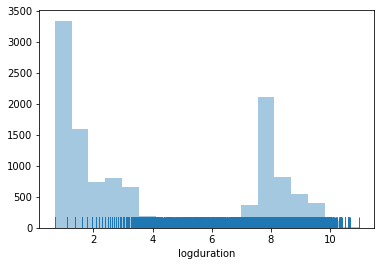

In [32]:
sns.distplot(data_1['logduration'], kde=False, rug=True)

In [33]:
data['target'] = data.apply(lambda x: 0 if 'normal' in x['attack_type'] else 1, axis=1)
data_1['target'] = data.apply(lambda x: 0 if 'normal' in x['attack_type'] else 1, axis=1)

/home/mateusz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
data_1['target'].value_counts() #the number of  activities in the network when duration is not zero

0    11690
1      660
Name: target, dtype: int64

In [35]:
data['target'].value_counts()#the number of  activities in the network 

1    396743
0     97278
Name: target, dtype: int64

In [36]:
#at this stage we can drop attack_type and attack_category.
data = data.drop(columns = ['attack_type','attack_category'])
data_1 = data_1.drop(columns = ['attack_type','attack_category'])
data.loc[:, (data != 0).any(axis=0)]
data_1.loc[:, (data_1 != 0).any(axis=0)]

,duration,src_bytes,dst_bytes,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,...,dst_host_srv_rerror_rate,tcp,udp,Other_x,http,private,Other_y,SF,logduration,target
216,1,1550,326,0,0,0,1,0,0,0,...,0.0,1,0,1,0,0,0,1,0.693147,0
383,79,231,328,0,0,0,1,0,0,0,...,0.0,1,0,0,1,0,0,1,4.382027,0
539,102,201,2613,0,0,0,1,0,0,0,...,0.0,1,0,0,1,0,0,1,4.634729,0
724,1,1596,329,0,0,0,1,0,0,0,...,0.0,1,0,1,0,0,0,1,0.693147,0
728,1,1148,327,0,0,0,1,0,0,0,...,0.0,1,0,1,0,0,0,1,0.693147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493740,9,148,18890,0,0,0,1,0,0,0,...,0.0,1,0,0,1,0,0,1,2.302585,0
493866,32,273,782,0,0,0,1,0,0,0,...,0.0,1,0,0,1,0,0,1,3.496508,0
493869,54,361,782,0,0,0,1,0,0,0,...,0.0,1,0,0,1,0,0,1,4.007333,0
493920,24,316,517,0,0,0,1,0,0,0,...,0.0,1,0,0,1,0,0,1,3.218876,0


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data['target'], test_size=0.2, 
                                                    random_state=42)

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [79]:
# building the optimal model using backward elimination
# SL = 0.05 and eliminating those features which have p > SL
import statsmodels.api as sm
X_train = np.append(arr = np.ones((395216,1)).astype(int), values = X_train, axis = 1)
X_train_opt = X_train[:,[0, 1, 2, 3, 4, 5, 6, 7, 8]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_train_opt).fit()
regressor_OLS.summary()
X_train_opt = X_train[:,[0, 2, 3, 4, 5, 6, 7, 8]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_train_opt).fit()
regressor_OLS.summary()
X_train_opt = X_train[:,[0, 2, 3, 4, 5, 6, 8]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_train_opt).fit()
regressor_OLS.summary()
X_train_opt = X_train[:,[0, 2, 3, 4, 5, 6]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_train_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1317.
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:56:37   Log-Likelihood:            -1.9327e+05
No. Observations:              395216   AIC:                         3.866e+05
Df Residuals:                  395210   BIC:                         3.866e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8028      0.001   1279.064      0.000       0.802       0.804
x1            -0.0475      0.001    -75.692      0.000      -0.049      -0.046
x2             0.0006      0.001      0.911      0.362      -0.001       0.002
x3            -0.0155      0.001    -24.654      0.000      -0.017      -0.014
x4             0.0011      0.001      1.700      0.089      -0.000       0.002
x5             0.0093      0.001     14.869      0.000       0.008       0.011
==============================================================================
Omnibus:                    84959.236   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           152030.605
Skew:                          -1.493   Prob(JB):                         0.00
Kurtosis:                       3.563   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
# Optimized training and test sets
# X_train_opt is optimized training set
y_train_opt = y_train
X_test = np.append(arr = np.ones((98805,1)).astype(int), values = X_test, axis = 1)
X_test_opt = X_test[:,[0, 2, 3, 4, 5, 6]]
y_test_opt = y_test

In [ ]:
#applying Recursive Feature Elimination for feature selection
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train, y_train)
selector.support_ 
selector.ranking_

Before feeding the data into the algorithm, perform PCA for feature selection and noise elimination. SVM tends to overfit the noise and is slow when dealing with high dimensional data sets.

In [ ]:
# Fitting Support Vector Machine (SVM) to the opt Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train_opt, y_train_opt)

# predicting the test set result
y_pred_svm = classifier.predict(X_test_opt)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test_opt, y_pred_svm)

/home/mateusz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [88]:
#Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = data['logduration'].values.reshape(-1,1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    4.940210e+05
mean    -5.878700e-13
std      1.000001e+00
min     -1.255477e-01
25%     -1.255477e-01
50%     -1.255477e-01
75%     -1.255477e-01
max      1.303563e+01
dtype: float64

In [30]:
#Experimenting with StandardScaler on the single 'logduration' feature in data_no_zero
from sklearn.preprocessing import StandardScaler

durations = data_no_zeros['logduration'].values.reshape(-1,1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.235000e+04
mean    -1.480145e-14
std      1.000040e+00
min     -1.067554e+00
25%     -9.436798e-01
50%     -4.519795e-01
75%      1.126033e+00
max      2.073316e+00
dtype: float64

In [90]:
#Let's proceed with StandardScaler - Apply to all the numeric columns

standard_scaler = StandardScaler().fit(data[numeric_cols])

data[numeric_cols] = \
    standard_scaler.transform(data[numeric_cols])

In [32]:
#similarly for data_no_zeros
standard_scaler = StandardScaler().fit(data_no_zeros[numeric_cols])

data_no_zeros[numeric_cols] = \
    standard_scaler.transform(data_no_zeros[numeric_cols])

/home/mateusz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/mateusz/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,logduration,target
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,0.0,0
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,0.0,0
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,0.0,0
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,0.0,0


In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data['target'], test_size=0.2, 
                                                    random_state=42)

In [98]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

def fit_model(data, target):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.1, random_state = 40)

    # TODO: Create a decision tree regressor object
    classifier = DecisionTreeClassifier(random_state=41)

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {"max_depth":range(1,11)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc =  make_scorer(accuracy_score)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(classifier, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(data, target)

    # Return the optimal model after fitting the data
    return grid.best_estimator_


In [75]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(model, X_train, y_train, cv=cv)  

NameError: name 'model' is not defined

In [40]:
X_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_category,logduration,target
133888,-0.067792,icmp,ecr_i,SF,-0.002017,-0.026287,0,-0.04772,-0.002571,-0.044136,...,0.827048,-0.158629,-0.464418,-0.463202,-0.252040,-0.249464,smurf.,dos,0.000000,1
67704,-0.067792,tcp,private,S0,-0.003062,-0.026287,0,-0.04772,-0.002571,-0.044136,...,-1.250621,-0.158629,2.163063,2.162027,-0.252040,-0.249464,neptune.,dos,0.000000,1
391027,-0.067792,tcp,private,S0,-0.003062,-0.026287,0,-0.04772,-0.002571,-0.044136,...,-1.250621,-0.158629,2.163063,2.162027,-0.252040,-0.249464,neptune.,dos,0.000000,1
372089,-0.067792,tcp,http,REJ,-0.003062,-0.026287,0,-0.04772,-0.002571,-0.044136,...,-1.001301,-0.158629,-0.464418,-0.463202,4.084676,4.095715,normal.,benign,0.000000,0
460597,-0.067792,tcp,private,REJ,-0.003062,-0.026287,0,-0.04772,-0.002571,-0.044136,...,-1.250621,-0.158629,-0.464418,-0.463202,4.084676,4.095715,neptune.,dos,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,-0.067792,icmp,ecr_i,SF,-0.002017,-0.026287,0,-0.04772,-0.002571,-0.044136,...,0.827048,-0.158629,-0.464418,-0.463202,-0.252040,-0.249464,smurf.,dos,0.000000,1
365838,-0.067792,tcp,private,S0,-0.003062,-0.026287,0,-0.04772,-0.002571,-0.044136,...,-1.250621,-0.158629,2.163063,2.162027,-0.252040,-0.249464,neptune.,dos,0.000000,1
131932,-0.067792,icmp,ecr_i,SF,-0.002017,-0.026287,0,-0.04772,-0.002571,-0.044136,...,0.827048,-0.158629,-0.464418,-0.463202,-0.252040,-0.249464,smurf.,dos,0.000000,1
146867,12.847863,udp,other,SF,-0.002913,-0.023109,0,-0.04772,-0.002571,-0.044136,...,0.494621,-0.158629,-0.464418,-0.463202,-0.252040,-0.249464,normal.,benign,9.120634,0


In [49]:
#X_train = X_train.drop(columns = ['attack_category','attack_type','protocol_type','service','flag'])
X_test = X_test.drop(columns = ['attack_category','attack_type','protocol_type','service','flag'])

In [58]:
#Fit Random Forest or SVM
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [59]:
y_pred = model.predict(X_test)

In [ ]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':['poly','ref'], 'C':[0.1,1,10]}

In [60]:
#create a scorer
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score

In [61]:
#create a GridSearch object
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)
grid_fit = grid_obj.fit(X,y)
#get the best estimator
best_clf = grid_fit.best_estimator_

NameError: name 'clf' is not defined

In [62]:

#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

#classifier = RandomForestClassifier(random_state=17)
#classifier.fit(X_train, y_train)



results = confusion_matrix(y_test, y_pred)
error = zero_one_loss(y_test, y_pred)

print(results)
print(error)



[[19352     1]
 [  163 79289]]
0.001659835028591683


In [57]:
# Fit the training data to the model using grid search
from sklearn.metrics import accuracy_score, make_scorer
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
#print( "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

TypeError: __init__() got an unexpected keyword argument 'n_iter'